In [5]:
import tensorflow as tf

In [7]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [8]:
tf.compat.v1.disable_eager_execution()

In [9]:
e = gym.make('CartPole-v0')

# New Section

# Experience Replay

In [10]:
from collections import namedtuple
from itertools import count
Transition = namedtuple('trans','state action next_state reward done')
class Replaymem(object):
    def __init__(self,cap):
        #kind of like circular queue
        self.cap = cap
        self.rear = 0
        self.mem = []
    def push(self,*s_a_ns_r_d):
        if(len(self.mem)<self.cap):
            self.mem.append(None)
        self.mem[self.rear]=Transition(*s_a_ns_r_d)
        self.rear = (self.rear+1)%self.cap
    def rsample(self,size_of_sample):
        experience = random.sample(self.mem,size_of_sample)
        l = len(experience)    
        buff = []
        for i in range(l):
            a = []
            a.append(experience[i].state)
            a.append(experience[i].action)
            a.append(experience[i].reward)
            a.append(experience[i].next_state)
            a.append(experience[i].done)
            buff.append(np.array(a))
        return np.reshape(np.array(buff),[l,5])
    def size(self):
        return len(self.mem)

In [71]:
class Replay_Buffer():
    def __init__(self,buffer_size):
        self.buffer = []
        self.buffer_size = buffer_size
    def push(self,experience):
        l = len(self.buffer)
        e = len(experience)
        if l + e >= self.buffer_size:
            self.buffer[0:l+e- self.buffer_size] =[]
        self.buffer.extend(experience)
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])
    def sample2(self,size):
        return np.reshape(np.array((self.buffer)),[size,5])

# Tensorflow Model

In [72]:
# class tfModel(tf.keras.Model):
#     def __init__(self, num_states, hidden_units, num_actions):
#         super(tfModel, self).__init__()
#         self.input_layer = tf.keras.layers.InputLayer(input_shape=(num_states,))
#         self.hidden_layers = []
#         for i in hidden_units:
#             self.hidden_layers.append(tf.keras.layers.Dense(
#                 i, activation='relu', kernel_initializer='RandomNormal'))
#         self.output_layer = tf.keras.layers.Dense(
#             num_actions,kernel_initializer='RandomNormal')

#     @tf.function
#     def call(self, inputs):
#         #shape of inputs [batch_size,size_of_state]
#         z = self.input_layer(inputs)
#         for layer in self.hidden_layers:
#             z = layer(z)
#         output = self.output_layer(z)
#         #shape of inputs [batch_size,number of actions outputs(2)]
#         return output

In [73]:
import datetime
class DQN():
    def __init__(self,eps,eps_decay,eps_update,hidden_layers,num_episodes,gamma,target_freq,batch_size,Memsize,learning_rate):
        self.eps = eps
        self.hidden_layers = hidden_layers
        self.eps_decay = eps_decay
        self.eps_up = eps_update
        self.NUM_EPISODES = num_episodes
        self.gamma = gamma
        self.target_up = target_freq
        self.batch_size = batch_size
        self.env = gym.make('CartPole-v0')
        self.num_state_size = 4
        self.num_action_size = 2
        self.ReplayMemSize = Memsize
        self.learning_rate = learning_rate
#         self.optimizer = tf.optimizers.Adam(learning_rate)
        self.current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        self.log_dir = './logs/dqn/'+'bestagain2'+'/'
#         self.summary_writer = tf.summary.create_file_writer(self.log_dir)
        print(self.current_time)
#         self.PrimaryNet = tfModel(self.num_state_size,self.hidden_layers,self.num_action_size)
#         self.PrimaryNet.compile(optimizer="Adam",loss="mse",metrics=["mae"])
#         self.TargetNet = tfModel(self.num_state_size,self.hidden_layers,self.num_action_size)
        

    def Q_network(self):
        
        ### The primary network

        # Initializing primary networks weights and biases
        # All the weights and biases of primary network
        self.x = tf.keras.backend.placeholder(dtype = tf.float32, shape= [None,self.num_state_size,], name = 'input')
        self.hidden_layer1_size = self.hidden_layers[0]
        self.hidden_layer2_size = self.hidden_layers[1]
        self.hidden_layer3_size = 2
        self.primary_weights = {
            'w1' : tf.Variable(np.random.normal(0, 0.01, size = (self.num_state_size, self.hidden_layer1_size)), dtype = tf.float32, name = "primary_weight1" ),
            'b1' : tf.Variable(np.random.normal(0, 0, size = (self.hidden_layer1_size)), dtype = tf.float32, name = "primary_bias1" ),
            'w2' : tf.Variable(np.random.normal(0, 0.01, size = (self.hidden_layer1_size, self.hidden_layer2_size)), dtype = tf.float32, name = "primary_weight2" ),
            'b2' : tf.Variable(np.random.normal(0, 0, size = (self.hidden_layer2_size)), dtype = tf.float32, name = "primary_bias2" ),
            'w3' : tf.Variable(np.random.normal(0, 0.01, size = (self.hidden_layer2_size, self.hidden_layer3_size)), dtype = tf.float32, name = "primary_weight3" ),
            'b3' : tf.Variable(np.random.normal(0, 0, size = (self.hidden_layer3_size)), dtype = tf.float32, name = "primary_bias3" )
        }

        # Defining the primary network
        p_h1 = tf.nn.relu(tf.add(tf.matmul(self.x, self.primary_weights['w1']), self.primary_weights['b1']))
        p_h2 = tf.nn.relu(tf.add(tf.matmul(p_h1, self.primary_weights['w2']), self.primary_weights['b2']))

        # Q value from primary network
        self.Q_primary = tf.add(tf.matmul(p_h2, self.primary_weights['w3']), self.primary_weights['b3'])
        self.maxQ_primary = tf.compat.v1.reduce_max(self.Q_primary,axis=1)
        self.Q_main_predict = tf.argmax(self.Q_primary,axis=1)
        ### The target network

        # Initializing target networks weights and biases
        # All the weights and biases of target network
        self.target_weights = {
            'w1' : tf.Variable(np.random.normal(0, 0.01, size = (self.num_state_size, self.hidden_layer1_size)), dtype = tf.float32, name = "target_weight1" ),
            'b1' : tf.Variable(np.random.normal(0, 0, size = (self.hidden_layer1_size)), dtype = tf.float32, name = "target_bias1" ),
            'w2' : tf.Variable(np.random.normal(0, 0.01, size = (self.hidden_layer1_size, self.hidden_layer2_size)), dtype = tf.float32, name = "target_weight2" ),
            'b2' : tf.Variable(np.random.normal(0, 0, size = (self.hidden_layer2_size)), dtype = tf.float32, name = "target_bias2" ),
            'w3' : tf.Variable(np.random.normal(0, 0.01, size = (self.hidden_layer2_size, self.hidden_layer3_size)), dtype = tf.float32, name = "target_weight3" ),
            'b3' : tf.Variable(np.random.normal(0, 0, size = (self.hidden_layer3_size)), dtype = tf.float32, name = "target_bias3" )
        }

        # Defining the target network
        t_h1 = tf.nn.relu(tf.add(tf.matmul(self.x, self.target_weights['w1']), self.target_weights['b1']))
        t_h2 = tf.nn.relu(tf.add(tf.matmul(t_h1, self.target_weights['w2']), self.target_weights['b2']))
        
        # Q value from target network
        self.Q_target = tf.matmul(t_h2, self.target_weights['w3']) + self.target_weights['b3']
        self.maxQ_target = tf.compat.v1.reduce_max(self.Q_target,axis=1)
        
        ### Loss and optimizer

        # We need to get the Q values for the actions performed so we multiply the 
        # one hot form of action to the Q values predicted from the primary network
        self.action = tf.keras.backend.placeholder(dtype = tf.int32, shape= [None], name = 'actions') 
#         self.one_hot_action = tf.one_hot(self.action, self.num_action_size, 1.0, 0.0, name = 'one_hot_action')
        self.one_hot_action = tf.one_hot(self.action, self.num_action_size,dtype = tf.float32, name = 'one_hot_action')
        self.predicted = tf.compat.v1.reduce_sum(tf.multiply(self.Q_primary, self.one_hot_action, name = 'predicted'),axis=1)
        # self.predicted = tf.placeholder(dtype = tf.float32, shape= [None], name = 'predicted')
        
        # We here get the reward + the output of Q values from target network
        self.expected = tf.keras.backend.placeholder(dtype = tf.float32, shape= [None], name = 'expected')

        # The mse loss        
        self.loss = tf.reduce_sum(tf.square(self.expected - self.predicted)) 
#         self.loss = tf.losses.mean_squared_error(self.expected, self.predicted)
        
        # Writing the summary to tensorboard
        # tf.summary.scalar('loss', self.loss)
        
        # to keep track of the number of updates made 
#        self.global_step_tensor = tf.train.get_or_create_global_step()                                                        
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        # optimizer updates the weights so as to decrease the loss, we chose adam optimizer
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = self.learning_rate).minimize(self.loss,global_step=self.global_step)

    def train(self):
        self.session = tf.compat.v1.Session()
        self.session.run(tf.compat.v1.global_variables_initializer())
        self.replay = Replay_Buffer(self.ReplayMemSize)
        summary_writer = tf.compat.v1.summary.FileWriter(self.log_dir)
        summary = tf.compat.v1.Summary()
        total_reward = np.zeros([self.NUM_EPISODES])
        total_steps = 0
        prev100 = []
        self.plot_100 = []
        self.plot = []
        for i in range(self.NUM_EPISODES):
            state = self.env.reset()
    
            steps = 0
            self.eps = max(0.05,self.eps*self.eps_decay)
            while True:
                action = self.get_action(state)
                next_state,reward,done,_ = self.env.step(action)
                steps+=1
                total_steps+=1
                total_reward[i]+=reward
                ns = np.reshape(next_state,[1,4])
                s = np.reshape(state,[1,4])
                self.replay.push(np.reshape(np.array([s,action,reward,ns,done]),[1,5]))
                if total_steps > self.batch_size:
                    ###Edit when Experience Replay is Removed
#                 if len(self.replay.buffer)==self.batch_size:
#                     mini_batch = self.replay.sample2(self.batch_size)
                    mini_batch = self.replay.sample(self.batch_size)
                    max_Q = self.session.run(self.maxQ_primary,feed_dict={self.x:np.vstack(mini_batch[:,3])})
                    target = mini_batch[:,2]+self.gamma * max_Q * (1-mini_batch[:,4])
                    _,cost= self.session.run([self.optimizer,self.loss],
                                                feed_dict={
                                                    self.x:np.vstack(mini_batch[:,0]),
                                                    self.expected:np.reshape(target,(None)),
                                                    self.action:np.reshape(mini_batch[:,1],(None))})
#                     loss_val = self.update(mini_batch)
#                 if total_steps%self.target_up ==0:
#                     for j in self.primary_weights:
#                         self.session.run(tf.compat.v1.assign(self.target_weights[j], self.primary_weights[j]))
                
#                 if total_steps%self.eps_up ==0:
#                     self.eps *= self.eps_decay
#                     if self.eps < 0.05:
#                         self.eps = 0.05
                state = next_state
                if done or steps >200:
                    break
            if(len(prev100)<100):
                prev100.append(steps)
            else:
                prev100[i%100]=steps
            hey = np.mean(prev100)
            self.plot_100.append(hey)
            self.plot.append(steps)
            print(i,hey)
            summary.value.add(tag = "Average total reward (number of steps per episode)", simple_value = hey)
            summary_writer.add_summary(summary, i)
            if(i%100==0):
                print(hey) 
            if(hey>=195):
                break
                
    def get_action(self,state):
#         print("random,",np.random.random())
        if np.random.random()<self.eps:
            return np.random.choice([0,1],p=[0.5,0.5])
        else:
            state = np.expand_dims(state, axis = 0)
            Q_values = self.session.run(self.Q_primary, feed_dict={self.x : state})
            # print(Q_values)
            return np.argmax(Q_values)
    def update(self,experience):
        l = len(experience)
        states = [experience[i].state for i in range(l)]
        actions = [experience[i].action for i in range(l)]
        rewards = [experience[i].reward for i in range(l)]
        next_states = [experience[i].next_state for i in range(l)]
        terminals =[experience[i].done for i in range(l)]
        
        for i in range(len(states)):
            expected_val = rewards[i]
            expected_val = np.expand_dims(expected_val, axis = 0)
            
            if not terminals[i]:
                next_states[i] = np.expand_dims(next_states[i], axis = 0)
                expected_val = self.gamma*np.amax(self.session.run(self.Q_target, feed_dict={self.x : next_states[i]}), axis=1) + rewards[i] 
            # expected_val = np.expand_dims(expected_val, axis = 0)
            states[i] = np.expand_dims(states[i], axis = 0)
            actions[i] = np.expand_dims(actions[i], axis = 0)

            _, loss_val = self.session.run([self.optimizer, self.loss], feed_dict={self.x : states[i], self.expected : expected_val, self.action : actions[i]})

        return loss_val
        
        

In [74]:
hidden = 120
# target_freq1 = 200 
target_freq2 = 1
# batch_size1 = 100
batch_size2 = 120
# dqn1 = DQN(0.5,0.99,20,[hidden,hidden],2000,0.9,target_freq1,batch_size1,10000,0.0025)
dqn2 = DQN(0.5,0.99,20,[hidden,hidden],2000,1,target_freq2,batch_size2,120,0.0001)

20200731-110740


In [75]:
# dqn1.Q_network()
dqn2.Q_network()

In [77]:
# dqn1.train()

dqn2

In [79]:
dqn2.train()

In [68]:
l = [
11.0,16.5,14.666666666666666,15.75,14.4,14.833333333333334,17.0,16.875,17.333333333333332,16.7,16.454545454545453,16.083333333333332,15.692307692307692,15.285714285714286,15.2,14.875,14.764705882352942,14.722222222222221,14.578947368421053,14.55,14.857142857142858,14.636363636363637,14.695652173913043,14.5,14.6,14.5,14.555555555555555,14.535714285714286,14.379310344827585,14.3,14.258064516129032,14.0625,14.030303030303031,14.0,13.885714285714286,13.805555555555555,13.783783783783784,13.868421052631579,13.76923076923077,13.7,13.609756097560975,13.523809523809524,13.511627906976743,13.477272727272727,13.4,13.304347826086957,13.212765957446809,13.125,13.122448979591837,13.1,13.058823529411764,13.057692307692308,12.981132075471699,12.944444444444445,12.963636363636363,12.892857142857142,12.842105263157896,12.793103448275861,12.796610169491526,12.766666666666667,12.721311475409836,12.693548387096774,12.634920634920634,12.59375,12.615384615384615,12.651515151515152,12.626865671641792,12.573529411764707,12.55072463768116,12.514285714285714,12.492957746478874,12.430555555555555,12.41095890410959,12.364864864864865,12.306666666666667,12.289473684210526,12.246753246753247,12.243589743589743,12.189873417721518,12.1625,12.11111111111111,12.085365853658537,12.060240963855422,12.011904761904763,11.988235294117647,11.953488372093023,11.931034482758621,11.909090909090908,11.92134831460674,11.9,11.912087912087912,11.91304347826087,11.881720430107526,11.882978723404255,11.852631578947369,11.822916666666666,11.814432989690722,11.785714285714286,11.787878787878787,11.79,11.77,11.66,11.67,11.56,11.55,11.48,11.44,11.37,11.26,11.25,11.23,11.22,11.22,11.23,11.18,11.19,11.16,11.13,11.11,11.07,10.96,10.97,10.89,10.89,10.8,10.78,10.72,10.68,10.67,10.65,10.62,10.64,10.6,10.58,10.62,10.62,10.59,10.53,10.53,10.51,10.5,10.49,10.49,10.52,10.7,10.76,10.79,10.94,10.94,11.01,11.0,11.0,11.04,11.05,11.16,11.16,11.29,11.33,11.3,11.41,11.63,11.74,11.74,11.97,11.97,11.96,12.03,12.09,12.17,12.42,12.51,12.52,12.53,12.53,12.58,12.59,12.59,12.58,12.6,12.76,12.94,12.97,13.03,13.17,13.18,13.19,13.18,13.18,13.14,13.15,13.25,13.5,13.74,13.76,13.82,13.91,13.96,13.98,14.14,14.24,14.37,14.55,14.67,14.76,14.84,16.27,16.69,17.18,17.31,18.28,18.7,19.15,19.71,20.3,20.87,21.74,22.29,22.86,23.09,23.38,23.96,24.51,25.23,25.63,25.88,26.14,26.69,27.25,27.47,27.7,27.94,28.59,29.15,30.17,30.7,31.14,31.58,32.11,32.58,32.97,33.55,34.33,34.81,35.49,35.72,36.24,36.79,37.34,38.27,39.1,40.01,41.2,41.91,42.81,43.39,44.25,45.15,46.56,47.88,49.66,51.19,52.61,53.88,55.35,56.9,58.64,60.23,61.57,62.82,64.26,65.64,66.99,68.87,70.62,72.47,74.03,75.78,77.39,78.94,80.68,82.42,84.29,86.13,87.91,89.8,91.7,93.61,95.51,97.42,99.14,100.91,102.54,104.21,106.07,107.92,109.74,111.58,113.47,115.19,116.97,118.75,120.46,122.22,124.05,125.89,126.36,127.68,129.1,130.87,131.8,133.26,134.7,136.03,137.33,138.67,139.69,141.04,142.36,144.03,145.64,146.96,148.3,149.5,151.0,152.67,154.31,155.66,157.0,158.69,160.36,162.02,163.27,164.62,165.49,166.82,168.27,169.73,171.09,172.52,174.04,175.37,176.5,177.89,179.06,180.55,181.88,183.21,184.42,185.36,186.34,187.33,188.01,189.17,190.15,191.32,192.37,193.24,193.69,194.27,194.27,194.42,194.78,195.42]


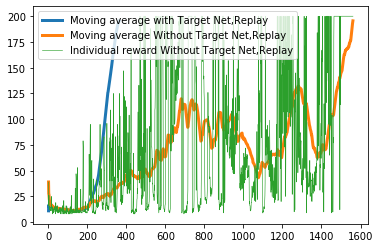

In [70]:

T = []
# num_episode=500
for i in range(len(dqn2.plot)):
    T.append(i+1)
T1 = []
# num_episode=500
for i in range(len(l)):
    T1.append(i+1)
plt.plot(T1,l,linewidth=3,label= "Moving average with Target Net,Replay")
plt.plot(T,dqn2.plot_100,linewidth=3,label= "Moving average Without Target Net,Replay")
plt.plot(T,dqn2.plot,linewidth = 0.6,label= "Individual reward Without Target Net,Replay")
plt.legend(loc = "upper left")
plt.show()


In [ ]:
##### TWo networks should be available
##### One for Training and one for Targets